In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 82% 122M/149M [00:00<00:00, 212MB/s] 
100% 149M/149M [00:00<00:00, 198MB/s]


In [3]:
 def get_class_paths(path):
  classes = []
  class_paths = []
  for label in os.listdir(path):
    label_path=os.path.join(path,label)
    if(os.path.isdir(label_path)):
      for image in os.listdir(label_path):
        image_path=os.path.join(label_path, image)
        classes.append(label)
        class_paths.append(image_path)
  df=pd.DataFrame({
      'Class Path': class_paths,
      'Class': classes
  })
  return df

In [4]:
tr_df=get_class_paths("/content/Training")
tr_df

,Class Path,Class
0,/content/Training/notumor/Tr-no_0794.jpg,notumor
1,/content/Training/notumor/Tr-no_1039.jpg,notumor
2,/content/Training/notumor/Tr-no_0972.jpg,notumor
3,/content/Training/notumor/Tr-no_0559.jpg,notumor
4,/content/Training/notumor/Tr-no_1252.jpg,notumor
...,...,...
5707,/content/Training/glioma/Tr-gl_0255.jpg,glioma
5708,/content/Training/glioma/Tr-gl_0182.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0553.jpg,glioma
5710,/content/Training/glioma/Tr-gl_0380.jpg,glioma


In [5]:
ts_df=get_class_paths("/content/Testing")
ts_df

,Class Path,Class
0,/content/Testing/notumor/Te-no_0097.jpg,notumor
1,/content/Testing/notumor/Te-no_0301.jpg,notumor
2,/content/Testing/notumor/Te-noTr_0000.jpg,notumor
3,/content/Testing/notumor/Te-no_0222.jpg,notumor
4,/content/Testing/notumor/Te-no_0139.jpg,notumor
...,...,...
1306,/content/Testing/glioma/Te-gl_0280.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0163.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0194.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0146.jpg,glioma


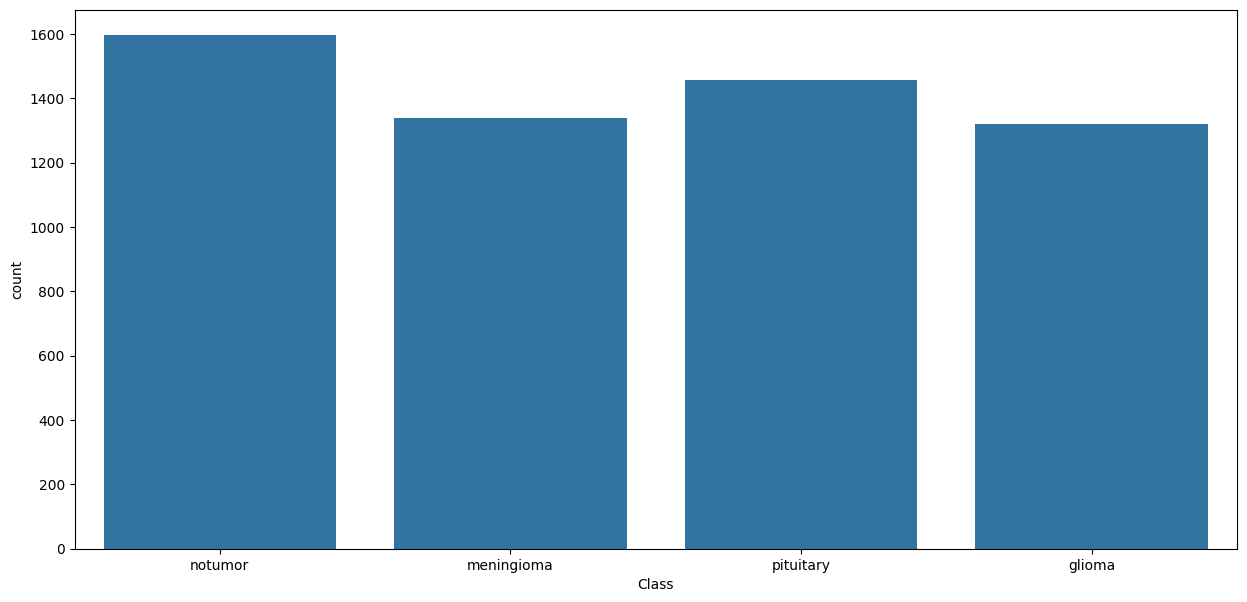

In [6]:
plt.figure(figsize=(15,7))
ax=sns.countplot(data=tr_df,x=tr_df['Class'])

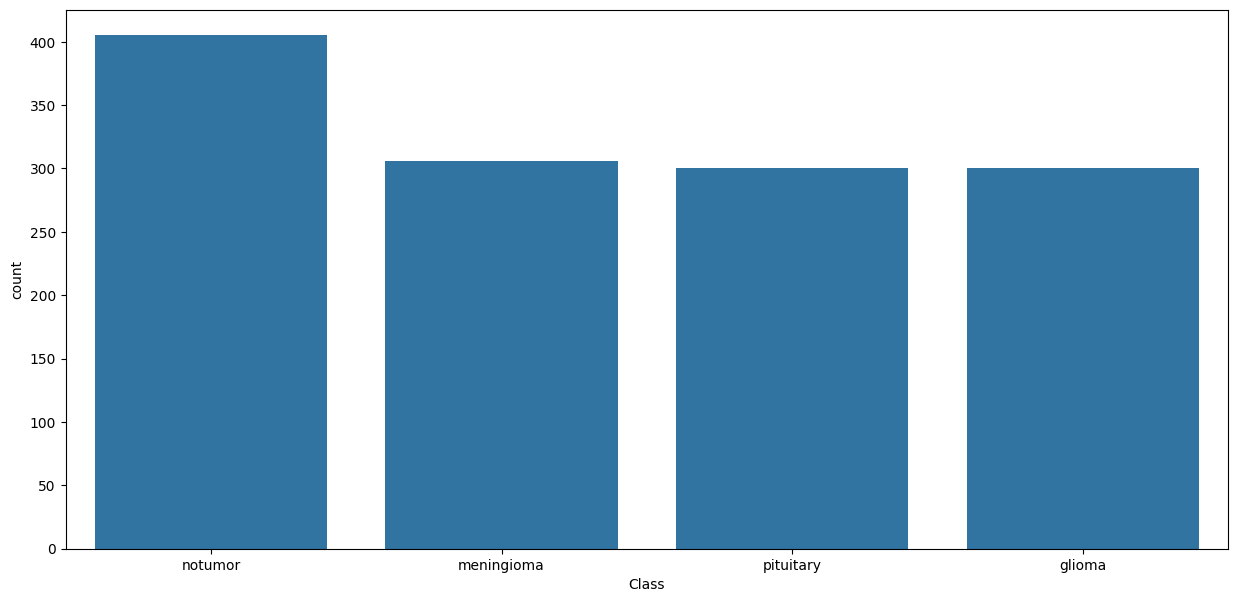

In [7]:
plt.figure(figsize=(15,7))
ax=sns.countplot(data=ts_df,x=ts_df['Class'])

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [9]:
valid_df,ts_df=train_test_split(ts_df,train_size=0.5,stratify=ts_df['Class'])

In [10]:
batch_size = 32
img_size=(299,299)
image_generator=ImageDataGenerator(rescale=1/255,brightness_range=(0.8,1.2))
ts_gen=ImageDataGenerator(rescale=1/255)
tr_gen=image_generator.flow_from_dataframe(tr_df,x_col='Class Path',y_col='Class',bath_size=batch_size,target_size=img_size)

Found 5712 validated image filenames belonging to 4 classes.


In [11]:
valid_gen=image_generator.flow_from_dataframe(valid_df,x_col='Class Path',y_col='Class',bath_size=batch_size,target_size=img_size)

Found 655 validated image filenames belonging to 4 classes.


In [12]:
ts_gen=image_generator.flow_from_dataframe(ts_df,x_col='Class Path',y_col='Class',bath_size=16,target_size=img_size,shuffle=False)


Found 656 validated image filenames belonging to 4 classes.


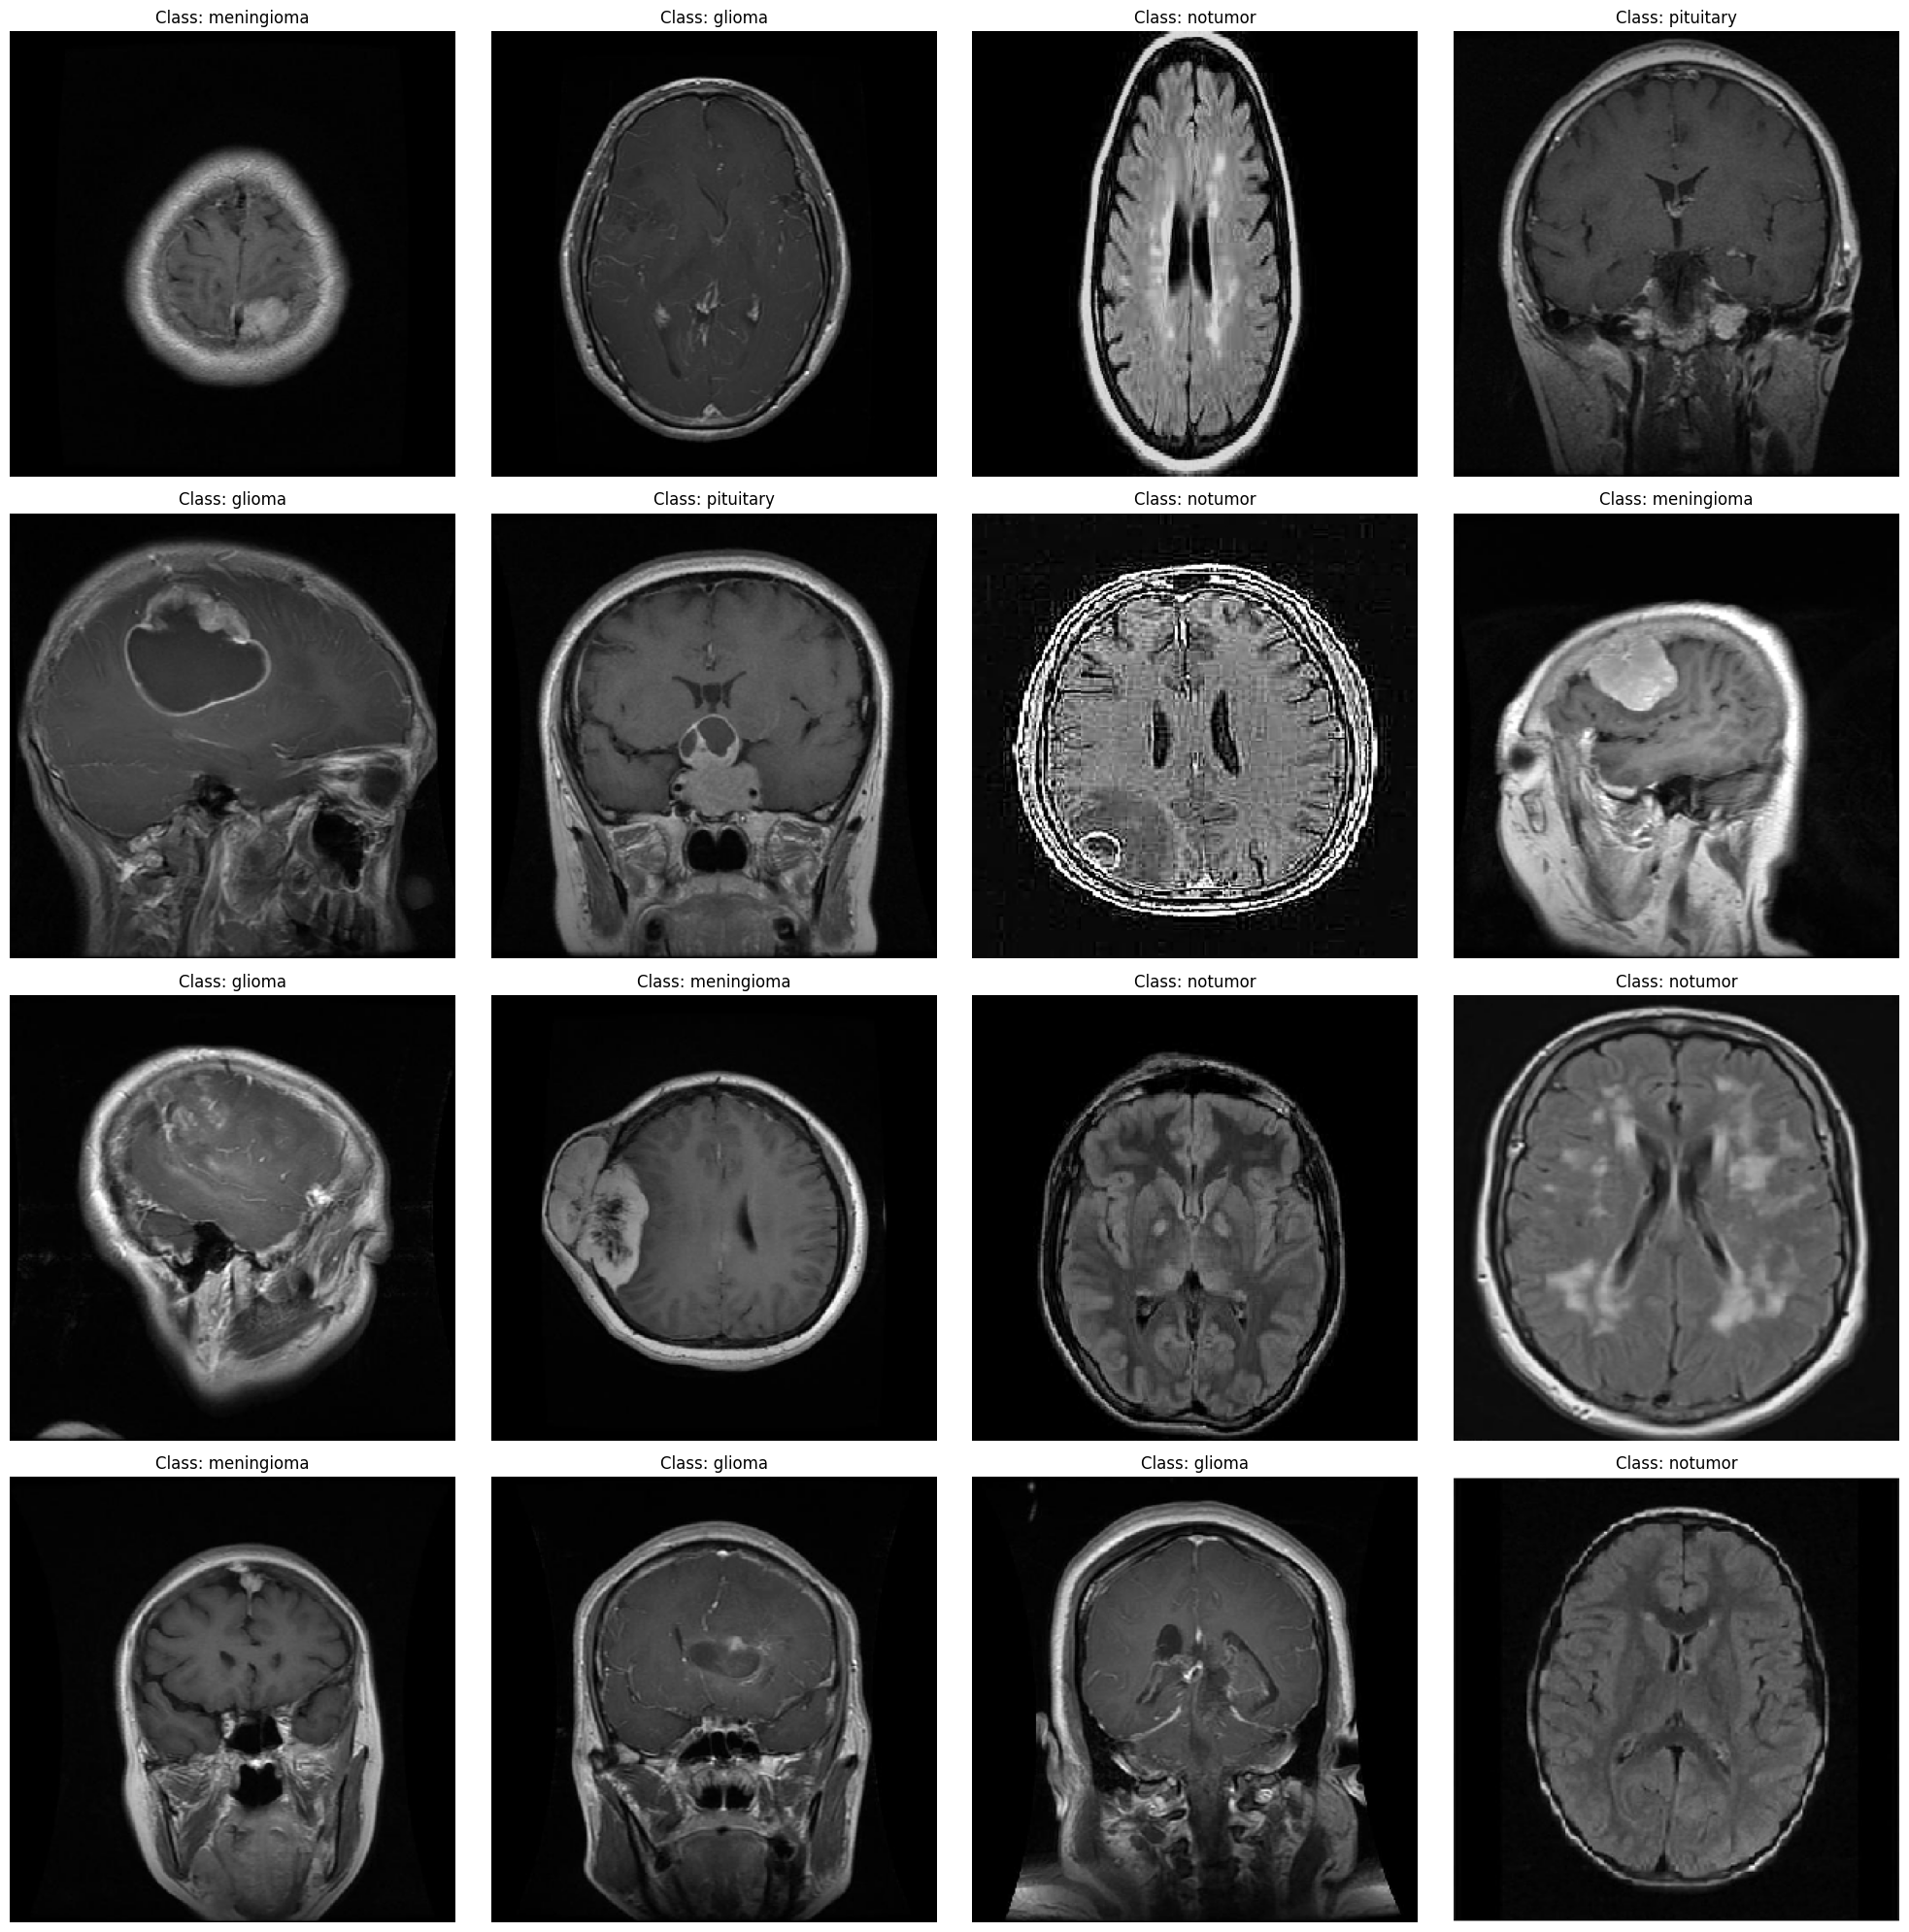

In [13]:
plt.figure(figsize=(20,20))
for i in range(16):
  plt.subplot(4,4,i+1)
  batch=next(tr_gen)
  image=batch[0][0]
  label=batch[1][0]
  plt.imshow(image)
  class_index=np.argmax(label)
  class_names=list(tr_gen.class_indices.keys())
  class_indices=list(tr_gen.class_indices.values())
  index_position=class_indices.index(class_index)
  class_name=class_names[index_position]
  plt.title(f"Class: {class_name}")
  plt.axis('off')
plt.tight_layout()
plt.show()


In [14]:
img_shape=(299,299,3)

base_model=tf.keras.applications.Xception(include_top=False,weights="imagenet",input_shape=img_shape,pooling='max')
model=Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128,activation='relu'),
    Dropout(rate=0.25),
    Dense(4,activation='softmax')
])



83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       Precision(),
                       Recall()])
hist=model.fit(tr_gen,epochs=5,validation_data=valid_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.7197 - loss: 0.8586 - precision: 0.8178 - recall: 0.5961 - val_accuracy: 0.7756 - val_loss: 0.8137 - val_precision: 0.7761 - val_recall: 0.7725
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 164s 865ms/step - accuracy: 0.9637 - loss: 0.1133 - precision: 0.9655 - recall: 0.9598 - val_accuracy: 0.8733 - val_loss: 0.3272 - val_precision: 0.8754 - val_recall: 0.8687
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 202s 868ms/step - accuracy: 0.9910 - loss: 0.0289 - precision: 0.9913 - recall: 0.9903 - val_accuracy: 0.8992 - val_loss: 0.3153 - val_precision: 0.9005 - val_recall: 0.8977
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 202s 864ms/step - accuracy: 0.9912 - loss: 0.0245 - precision: 0.9920 - recall: 0.9907 - val_accuracy: 0.9832 - val_loss: 0.0372 - val_precision: 0.9832 - val_recall: 0.9832
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 157s 867ms/step - accuracy: 0.9978 - loss: 0.0084 - precision: 0.9981 - recall: 0.9977 - val_accuracy: 0.9924 - val_loss: 

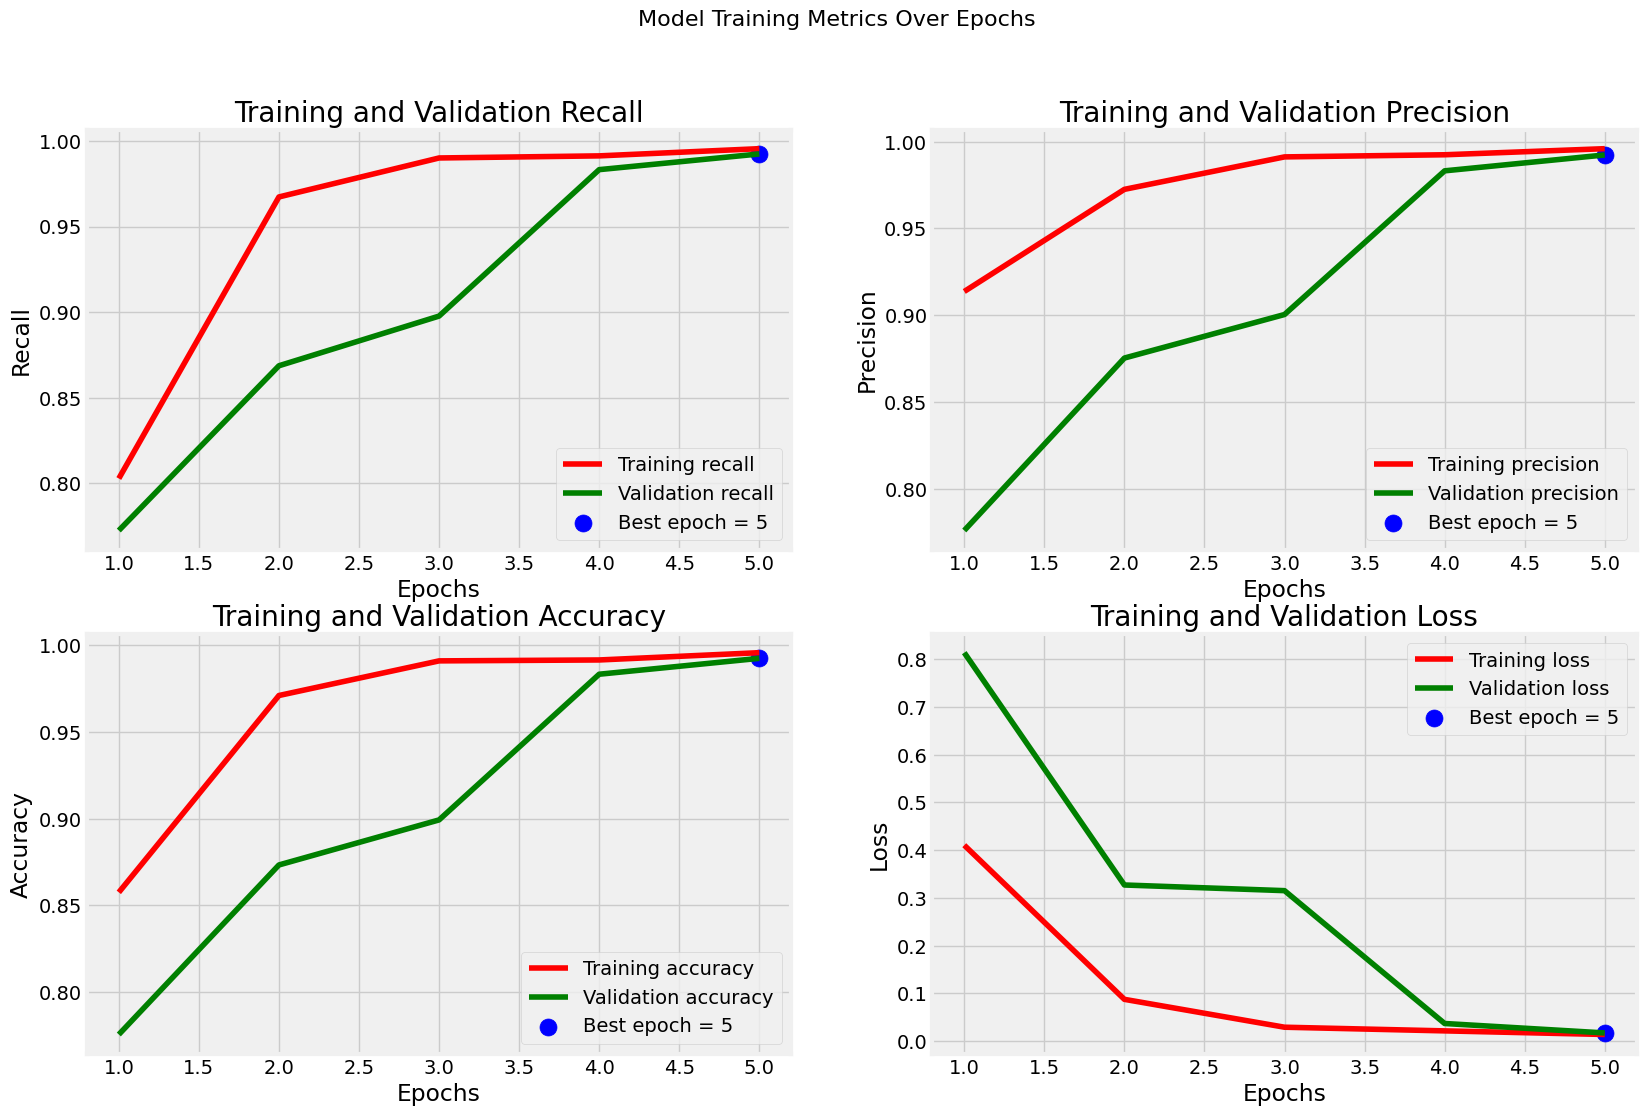

In [16]:
metrics={'accuracy','loss','precision','recall'}
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}
best_epochs={}
best_values={}
for m in metrics:
  if m=='loss':
    idx=np.argmin(val_metrics[m])
  else:
    idx=np.argmax(val_metrics[m])
  best_epochs[m]=idx+1
  best_values[m]=val_metrics[m][idx]
plt.figure(figsize=(20,12))
plt.style.use('fivethirtyeight')
for i, metric in enumerate(metrics,1):
  plt.subplot(2,2,i)
  epochs=range(1,len(tr_metrics[metric])+1)
  plt.plot(epochs,tr_metrics[metric],'r',label=f'Training {metric}')
  plt.plot(epochs,val_metrics[metric],'g',label=f'Validation {metric}')
  plt.scatter(best_epochs[metric],best_values[metric],s=150,c='blue',label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)
plt.suptitle('Model Training Metrics Over Epochs',fontsize=16)
plt.show()

In [17]:
train_score=model.evaluate(tr_gen,verbose=1)
valid_score=model.evaluate(valid_gen,verbose=1)
test_score=model.evaluate(ts_gen,verbose=1)

print(f'Train Accuracy: {train_score[1]*100:0.2f}%')
print(f'Train Loss: {train_score[0]:0.4f}')

print(f'\n\nValidation Accuracy: {valid_score[1]*100:0.2f}%')
print(f'Valid Loss: {valid_score[0]:0.4f}')

print(f'\n\nTest Accuracy: {test_score[1]*100:0.2f}%')
print(f'Test Loss: {test_score[0]:0.4f}')

179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 251ms/step - accuracy: 0.9995 - loss: 0.0019 - precision: 0.9995 - recall: 0.9995
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.9951 - loss: 0.0146 - precision: 0.9951 - recall: 0.9951


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.9872 - loss: 0.0276 - precision: 0.9872 - recall: 0.9872
Train Accuracy: 99.93%
Train Loss: 0.0022


Validation Accuracy: 99.24%
Valid Loss: 0.0206


Test Accuracy: 98.78%
Test Loss: 0.0290


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step


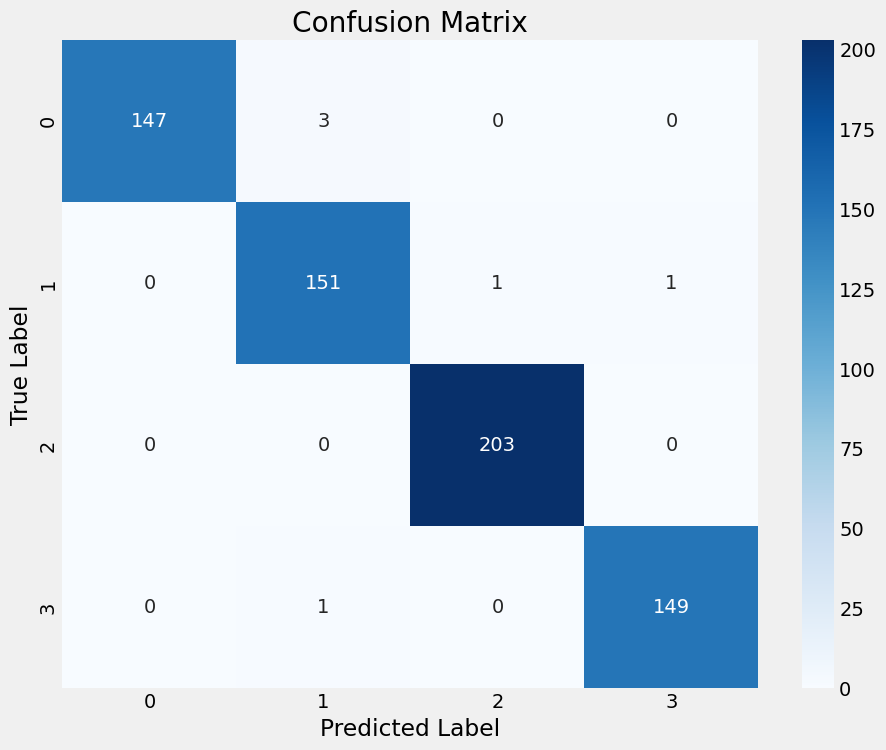

In [18]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
class_dict={
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}
cm=confusion_matrix(ts_gen.classes,y_pred)
labels=list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
from PIL import Image
def predict(img_path: str) -> None:
  labels=list(class_dict.keys())
  plt.figure(figsize=(6,8))
  img=Image.open(img_path)
  resized_img=img.resize((299,299))
  img_array = np.asarray(resized_img)
  img_array = np.expand_dims(img_array,axis=0)/255
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])
  predicted_class_idx=np.argmax(probabilities)
  predicted_class=class_dict[predicted_class_idx]
  plt.subplot(2,1,1)
  plt.imshow(resized_img)
  plt.title(f"Input MRI Image\nPredicted: {predicted_class}")
  plt.subplot(2,1,2)
  bars=plt.barh(labels,probabilities)
  plt.xlabel("Probability",fontsize=15)
  plt.title("Class Probabilities")

  ax=plt.gca()
  ax.bar_label(bars,fmt="%.2f")
  plt.tight_layout()
  plt.show()
  print(f"\nPredicted tumor type: {predicted_class}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


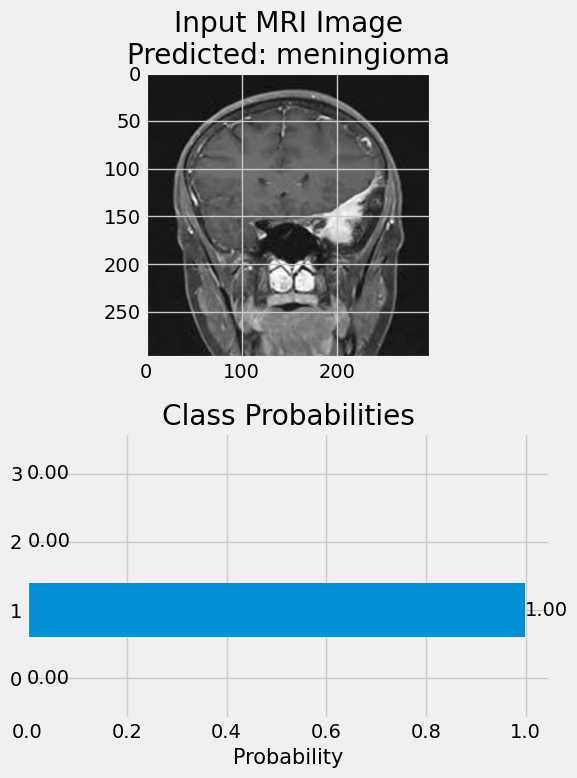


Predicted tumor type: meningioma


In [20]:
predict("/content/Testing/meningioma/Te-meTr_0003.jpg")

In [21]:
model.save_weights("xception_model.weights.h5")

In [22]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
batch_size = 16
img_size=(224,224)
image_generator=ImageDataGenerator(rescale=1/255,brightness_range=(0.8,1.2))
ts_gen=ImageDataGenerator(rescale=1/255)
tr_gen=image_generator.flow_from_dataframe(tr_df,x_col='Class Path',y_col='Class',bath_size=batch_size,target_size=img_size)
valid_gen=image_generator.flow_from_dataframe(valid_df,x_col='Class Path',y_col='Class',bath_size=batch_size,target_size=img_size)
ts_gen=image_generator.flow_from_dataframe(ts_df,x_col='Class Path',y_col='Class',bath_size=16,target_size=img_size,shuffle=False)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [23]:
cnn_model=Sequential()
cnn_model.add(Conv2D(512,(3,3),padding='same',input_shape=(224,224,3),activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))
cnn_model.add(Dense(4,activation='softmax'))
cnn_model.compile(Adamax(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy',Precision(),Recall()])
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,775,620 (18.22 MB)

 Trainable params: 4,775,620 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history=cnn_model.fit(tr_gen,epochs=5,validation_data=valid_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 220s 947ms/step - accuracy: 0.5242 - loss: 2.9535 - precision_1: 0.6270 - recall_1: 0.2963 - val_accuracy: 0.7466 - val_loss: 1.1758 - val_precision_1: 0.8004 - val_recall_1: 0.6733
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 595ms/step - accuracy: 0.7653 - loss: 1.0136 - precision_1: 0.7961 - recall_1: 0.7211 - val_accuracy: 0.8076 - val_loss: 0.7613 - val_precision_1: 0.8413 - val_recall_1: 0.7771
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 143s 600ms/step - accuracy: 0.8319 - loss: 0.7124 - precision_1: 0.8492 - recall_1: 0.8046 - val_accuracy: 0.8290 - val_loss: 0.6249 - val_precision_1: 0.8585 - val_recall_1: 0.8061
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 141s 599ms/step - accuracy: 0.8725 - loss: 0.5484 - precision_1: 0.8836 - recall_1: 0.8522 - val_accuracy: 0.8687 - val_loss: 0.5020 - val_precision_1: 0.8784 - val_recall_1: 0.8489
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 608ms/step - accuracy: 0.8879 - loss: 0.4743 - precision_1: 0.8919 - recall_1: 0.8

In [25]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_loss', 'val_precision_1', 'val_recall_1'])

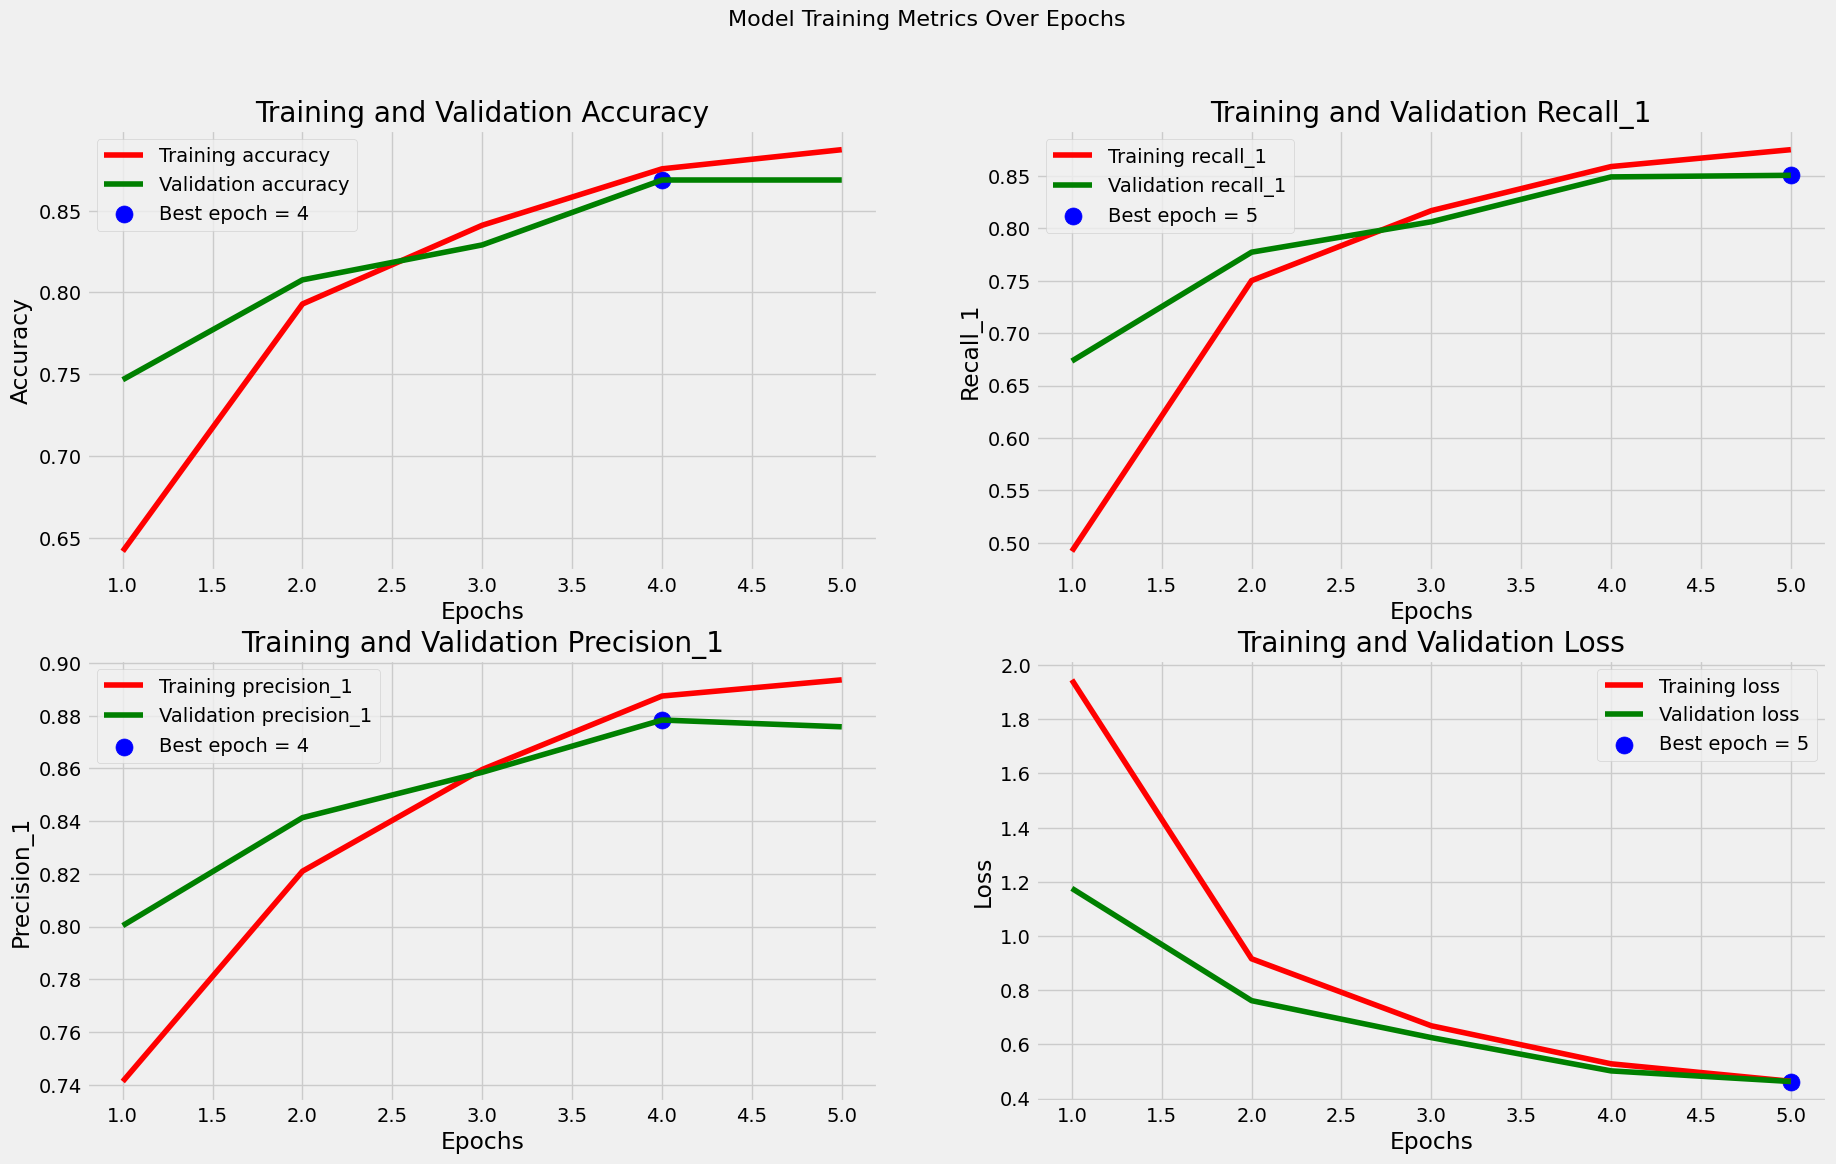

In [27]:
metrics={'accuracy','loss','precision_1','recall_1'}
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}
best_epochs={}
best_values={}
for m in metrics:
  if m=='loss':
    idx=np.argmin(val_metrics[m])
  else:
    idx=np.argmax(val_metrics[m])
  best_epochs[m]=idx+1
  best_values[m]=val_metrics[m][idx]
plt.figure(figsize=(20,12))
plt.style.use('fivethirtyeight')
for i, metric in enumerate(metrics,1):
  plt.subplot(2,2,i)
  epochs=range(1,len(tr_metrics[metric])+1)
  plt.plot(epochs,tr_metrics[metric],'r',label=f'Training {metric}')
  plt.plot(epochs,val_metrics[metric],'g',label=f'Validation {metric}')
  plt.scatter(best_epochs[metric],best_values[metric],s=150,c='blue',label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)
plt.suptitle('Model Training Metrics Over Epochs',fontsize=16)
plt.show()

In [28]:
train_score=cnn_model.evaluate(tr_gen,verbose=1)
valid_score=cnn_model.evaluate(valid_gen,verbose=1)
test_score=cnn_model.evaluate(ts_gen,verbose=1)

print(f'Train Accuracy: {train_score[1]*100:0.2f}%')
print(f'Train Loss: {train_score[0]:0.4f}')

print(f'\n\nValidation Accuracy: {valid_score[1]*100:0.2f}%')
print(f'Valid Loss: {valid_score[0]:0.4f}')

print(f'\n\nTest Accuracy: {test_score[1]*100:0.2f}%')
print(f'Test Loss: {test_score[0]:0.4f}')

179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 206ms/step - accuracy: 0.8869 - loss: 0.4168 - precision_1: 0.8933 - recall_1: 0.8802
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.8895 - loss: 0.4271 - precision_1: 0.8931 - recall_1: 0.8769


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.8417 - loss: 0.4965 - precision_1: 0.8575 - recall_1: 0.8319
Train Accuracy: 88.53%
Train Loss: 0.4151


Validation Accuracy: 86.87%
Valid Loss: 0.4631


Test Accuracy: 84.91%
Test Loss: 0.4969


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step


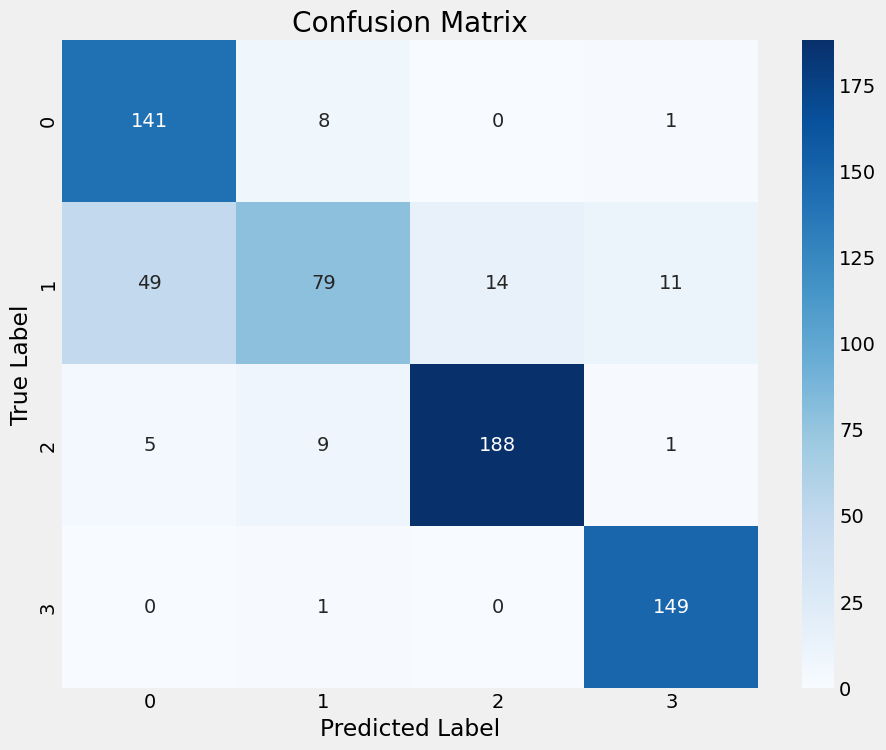

In [29]:
preds = cnn_model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)
class_dict={
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}
cm=confusion_matrix(ts_gen.classes,y_pred)
labels=list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
clr=classification_report(ts_gen.classes,y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.72      0.94      0.82       150
           1       0.81      0.52      0.63       153
           2       0.93      0.93      0.93       203
           3       0.92      0.99      0.96       150

    accuracy                           0.85       656
   macro avg       0.85      0.84      0.83       656
weighted avg       0.85      0.85      0.84       656



In [31]:
cnn_model.save("cnn_model.h5")

# Web App


In [32]:
! pip install streamlit pyngrok python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.8 MB/s eta 0:00:00


In [33]:
from threading import Thread
from pyngrok import ngrok
from google.colab import userdata

In [35]:
ngrok_token=userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_token)


In [36]:
def run_streamlit():
  os.system('streamlit run /content/app.py --server.port 8501')

In [48]:
%%writefile app.py

import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import plotly.graph_objects as go
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
import google.generativeai as genai
from google.colab import userdata
import PIL.Image
import os
from dotenv import load_dotenv
load_dotenv()
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
output_dir='saliency_maps'
os.makedirs(output_dir,exist_ok=True)

def generate_explanations(img_path,model_prediction,confidence):
  prompt=f"""You are an expert neurologist. You are tasked with explaining a saliency map of a brain tumor MRI scan.
  The saliency map was generated by a deep learning model that was trained to classify brain tumors as either glioma,
  meningioma, pituitary, or no tumor.

  The saliency map highlights the regions of the image that the machine learning model is focusing on to make the prediction.

  The deep learning model predicted the image to be of class '{model_prediction}' with a confidence of {confidence*100}%

  In your response:
  - Explain what regions of the brain the model is focusing on, based on the saliency map. Refer to the regions highlighted
  in light cyan, those are the regions where the model is focusing on.
  - Don't mention anything like 'The salivency map highlights the regions the model is focusing on, which are in light cyan'
  in your explanation.
  -Keep your explanation to 4 sentences max.
  """
  img=PIL.Image.open(img_path)

  model=genai.GenerativeModel(model_name='gemini-1.5-flash')
  response=model.generate_content([prompt,img])
  return response.text



def generate_saliency_map(model, img_array, class_index, img_size):
  with tf.GradientTape() as tape:
    img_tensor = tf.convert_to_tensor(img_array)
    tape.watch(img_tensor)
    predictions=model(img_tensor)
    target_class = predictions[:, class_index]

  gradients=tape.gradient(target_class,img_tensor)
  gradients = tf.math.abs(gradients)
  gradients = tf.reduce_max(gradients, axis=-1)
  gradients = gradients.numpy().squeeze()

  gradients = cv2.resize(gradients, img_size)
  center = (gradients.shape[0] // 2, gradients.shape[1]//2)
  radius=min(center[0],center[1])-10
  y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]

  mask = (x-center[0])**2 + (y-center[1])**2 <=radius**2

  gradients = gradients * mask

  brain_gradients = gradients[mask]
  if brain_gradients.max() > brain_gradients.min():
    brain_gradients = (brain_gradients-brain_gradients.min())/(brain_gradients.max()-brain_gradients.min())
  gradients[mask]=brain_gradients

  threshold = np.percentile(gradients[mask],80)
  gradients[gradients<threshold]=0

  gradients = cv2.GaussianBlur(gradients,(11,11),0)

  heatmap=cv2.applyColorMap(np.uint8(255*gradients),cv2.COLORMAP_JET)
  heatmap=cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)

  heatmap = cv2.resize(heatmap,img_size)

  original_img = image.img_to_array(img)
  superimposed_img = heatmap*0.7+original_img*0.3
  superimposed_img=superimposed_img.astype(np.uint8)

  img_path = os.path.join(output_dir,uploaded_file.name)
  with open(img_path,"wb") as f:
    f.write(uploaded_file.getbuffer())
  saliency_map_path=f'saliency_maps/{uploaded_file.name}'

  cv2.imwrite(saliency_map_path,cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))
  return superimposed_img





def load_xception_model(model_path):
  img_shape=(299,299,3)
  base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet',input_shape=img_shape,pooling='max')
  model=Sequential([
      base_model,
      Flatten(),
      Dropout(rate=0.3),
      Dense(128,activation='relu'),
      Dropout(rate=0.25),
      Dense(4,activation='softmax')
  ])
  model.build((None, )+img_shape)
  model.compile(Adamax(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy',Precision(),Recall()])
  model.load_weights(model_path)
  return model
st.title("Brain Tumor Classification")
st.write("Upload an image of a brain MRI scan to classify.")

uploaded_file=st.file_uploader("Choose an image...",type=["jpg",'jpeg','png'])
if uploaded_file is not None:
  selected_model=st.radio("Select Model",
                          ("Transfer Learning - Xception", "Custom CNN"))
  if(selected_model=="Transfer Learning - Xception"):
    model=load_xception_model('/content/xception_model.weights.h5')
    img_size=(299,299)
  else:
    model = load_model('/content/cnn_model.h5')
    img_size=(224,224)

  labels = ['Glioma', ' Meningioma', 'No tumor', 'Pituitary']
  img = image.load_img(uploaded_file,target_size=img_size)
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0

  prediction=model.predict(img_array)

  class_index=np.argmax(prediction[0])
  result=labels[class_index]
  # st.write(f"Predicted Class: {result}")
  # st.write("Predictions: ")
  # for label, prob in zip(labels, prediction[0]):
  #   st.write(f"{label}: {prob:0.4f}")

  saliency_map = generate_saliency_map(model,img_array,class_index,img_size)
  col1,col2=st.columns(2)
  with col1:
    st.image(uploaded_file, caption='Uploaded Image', use_container_width=True)
  with col2:
    st.image(saliency_map,caption= 'Saliency Map', use_container_width=True)


  result_container=st.container()
  result_container.markdown(
      f"""
    <div style="background-color: #000000; color: #ffffff; padding: 30px; border-radius: 15px;">
      <div style="display: flex; justify-content: space-between; align-items: center;">
        <div style="flex: 1; text-align: center;">
          <h3 style="color: #ffffff; margin-bottom: 10px; font-size: 20px;">Prediction</h3>
          <p style="font-size: 36px; font-weight:800; color: #FF0000; margin: 0;">
            {result}
          </p>
        </div>
        <div style="width: 2px; height: 80px; background-color: #ffffff; margin: 0 20px;"></div>
        <div style="flex: 1; text-align: center;">
          <h3 style="color: #ffffff; margin-bottom: 10px; font-size: 20px;">Confidence</h3>
          <p style="font-size: 36px; font-weight: 800; color: #2196F3; margin: 0;">
            {prediction[0][class_index]:.4%}
          </p>
        </div>
      </div>
    </div>
    """,
    unsafe_allow_html=True
  )
  probabilities=prediction[0]
  sorted_indices=np.argsort(probabilities)[::-1]
  sorted_labels = [labels[i] for i in sorted_indices]
  sorted_probabilities=probabilities[sorted_indices]
  fig=go.Figure(go.Bar(
      x=sorted_probabilities,
      y=sorted_labels,
      orientation='h',
      marker_color=['red' if label == result else 'blue' for label in sorted_labels]
  ))
  fig.update_layout(
      title="Probabilities for each class",
      xaxis_title="Probability",
      yaxis_title='Class',
      height=400,
      width=600,
      yaxis=dict(autorange='reversed')
  )
  for i, prob in enumerate(sorted_probabilities):
    fig.add_annotation(
        x=prob,
        y=i,
        text=f'{prob:.4f}',
        showarrow=False,
        xanchor='left',
        xshift=5
    )
  st.plotly_chart(fig)
  saliency_map_path=f'saliency_maps/{uploaded_file.name}'
  explanation = generate_explanations(saliency_map_path, result, prediction[0][class_index])

  st.write("## Explanation")
  st.write(explanation)




Overwriting app.py


In [38]:
thread = Thread(target=run_streamlit)
thread.start()

In [39]:
public_url = ngrok.connect(addr='8501',proto = 'http',bind_tls = True)
print("Public URL: ", public_url)

Public URL:  NgrokTunnel: "https://0d99-34-145-109-102.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
  print(f"Closing tunnel: {tunnel.public_url} -> {tunnel.config['addr']}")
  ngrok.disconnect(tunnel.public_url)

In [45]:
#%%writefile .env

#GOOGLE_API_KEY=

Overwriting .env
